# Balancing Privacy and Accuracy in Machine Learning Models with Differential Privacy

## 1. Introduction & Problem Statement

This project explores how **Differential Privacy Stochastic Gradient Descent (DP-SGD)** and **Model Agnostic Private Learning (MAPL)** impact machine learning models. Specifically, we examine whether DP techniques interfere with model accuracy and the evolution of machine learning.

## 2. Setup - Install Required Packages

Run the code below if there are missing packages:

In [5]:
%pip install matplotlib
%pip install seaborn
%pip install pandas numpy
%pip install scikit-learn
%pip install ucimlrepo
%pip install imblearn
%pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 3. Data Exploration & Understanding

We are importing the relevant libraries and getting the data:

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo #to retrieve the dataset

# Getting the data
dataset_id = 891  # our chosen dataset
dataset = fetch_ucirepo(id=dataset_id)
df = dataset.data.original

# # Previous way to retrieve the dataset (dor documentation)
# url = 'https://archive.ics.uci.edu/static/public/891/data.csv'
# df = pd.read_csv(url)

# Set display options
pd.set_option('display.max_columns', None)


We have observed that the dataset contains 253,680 records with 23 features:

In [7]:
# Checking basic Dataset Information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (253680, 23)

First 5 rows:


,ID,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,1,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3
1,1,0,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1
2,2,0,1,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8
3,3,0,1,0,1,27,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6
4,4,0,1,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4


We have observed that all features are stored as integer data types:

The following table shows the features and their descriptions:

| Variable Name     | Role    | Type    | Description                                                                 |
|-------------------|---------|---------|-----------------------------------------------------------------------------|
| ID                | ID      | Integer | Patient ID                                                                  |
| Diabetes_binary   | Target  | Binary  | 0 = no diabetes 1 = prediabetes or diabetes                                 |
| HighBP            | Feature | Binary  | 0 = no high BP 1 = high BP                                                  |
| HighChol          | Feature | Binary  | 0 = no high cholesterol 1 = high cholesterol                                |
| CholCheck         | Feature | Binary  | 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years    |
| BMI               | Feature | Integer | Body Mass Index                                                             |
| Smoker            | Feature | Binary  | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes |
| Stroke            | Feature | Binary  | (Ever told) you had a stroke. 0 = no 1 = yes                                |
| HeartDiseaseorAttack | Feature | Binary | coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes  |
| PhysActivity      | Feature | Binary  | physical activity in past 30 days - not including job 0 = no 1 = yes        |
| Fruits            | Feature | Binary  | Consume Fruit 1 or more times per day 0 = no 1 = yes                        |
| Veggies           | Feature | Binary  | Consume Vegetables 1 or more times per day 0 = no 1 = yes                   |
| HvyAlcoholConsump | Feature | Binary  | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes |
| AnyHealthcare     | Feature | Binary  | Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes |
| NoDocbcCost       | Feature | Binary  | Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes |
| GenHlth           | Feature | Integer | General health: 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor |
| MentHlth          | Feature | Integer | For how many days during the past 30 days was your mental health not good? scale 1-30 days |
| PhysHlth          | Feature | Integer | For how many days during the past 30 days was your physical health not good? scale 1-30 days |
| DiffWalk          | Feature | Binary  | Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes   |
| Sex               | Feature | Binary  | 0 = female 1 = male                                                    |
| Age               | Feature | Integer | 13 levels, 1 = 18-24, 9 = 60-64, 13 = 80 or older              |
| Education         | Feature | Integer | 6 levels, 1 = Never attended school or only kindergarten, 2 = Grades 1 through 8, 3 = Grades 9 through 11, 4 = Grade 12 or GED, 5 = College 1 year to 3 years, 6 = College 4 years or more |
| Income            | Feature | Integer | 8 levels, 1 = less than $10,000, 5 = less than $35,000, 8 = $75,000 or more |


In [8]:
# Checking data types
print("\nData Types:")
print(df.dtypes)


Data Types:
ID                      int64
Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object


We have observed basic statistics for the features:

In [9]:
# Checking basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
                  ID  Diabetes_binary         HighBP       HighChol  \
count  253680.000000    253680.000000  253680.000000  253680.000000   
mean   126839.500000         0.139333       0.429001       0.424121   
std     73231.252481         0.346294       0.494934       0.494210   
min         0.000000         0.000000       0.000000       0.000000   
25%     63419.750000         0.000000       0.000000       0.000000   
50%    126839.500000         0.000000       0.000000       0.000000   
75%    190259.250000         0.000000       1.000000       1.000000   
max    253679.000000         1.000000       1.000000       1.000000   

           CholCheck            BMI         Smoker         Stroke  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.962670      28.382364       0.443169       0.040571   
std         0.189571       6.608694       0.496761       0.197294   
min         0.000000      12.000000       0.000000       0.000000

We have observed that there are no missing values (as stated in the dataset description):

In [10]:
# Checking for missing values
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


ID                      0
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

We have observed that the dataset only has 13.93% records with diabetes. We will address this imbalance later during data cleaning and preprocessing:

In [11]:
# Checking distribution of dataset
diabetes_counts = df['Diabetes_binary'].value_counts()
print("Distribution of target variable:")
print(diabetes_counts)
print(f"Percentage of records with diabetes: {diabetes_counts[1]/len(df)*100:.2f}%")

Distribution of target variable:
0    218334
1     35346
Name: Diabetes_binary, dtype: int64
Percentage of records with diabetes: 13.93%


We have observed a basic relationship between the features using a correlation matrix. We still need to explain what we can see from this:

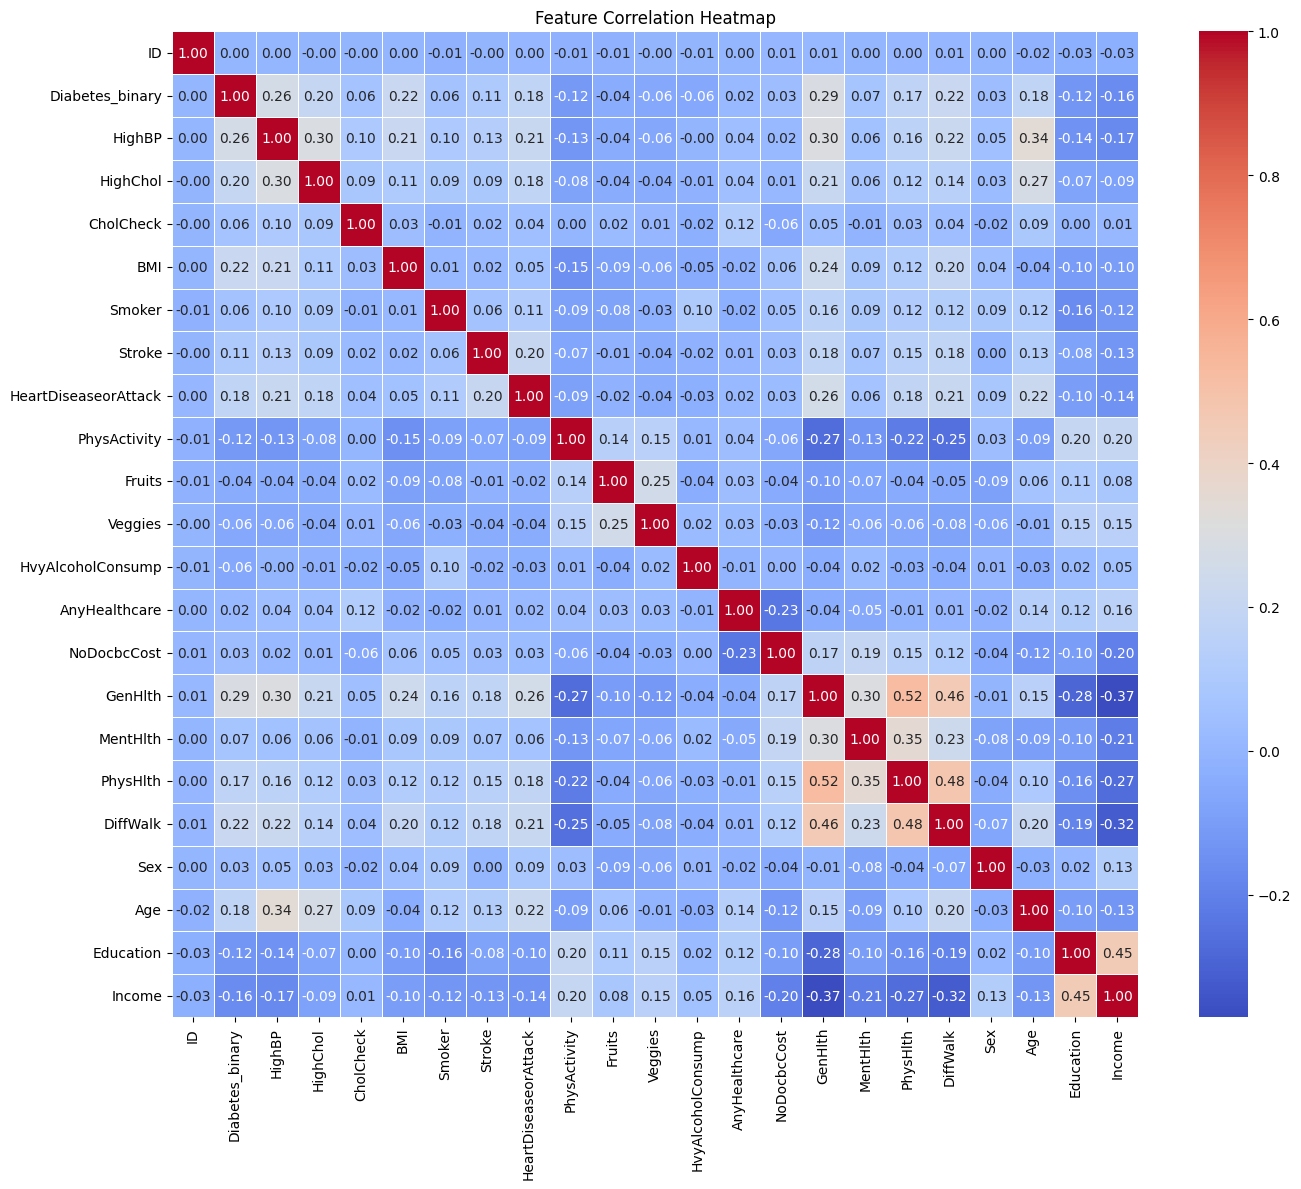


Features correlated with Diabetes (sorted):
Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
ID                      0.004268
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64


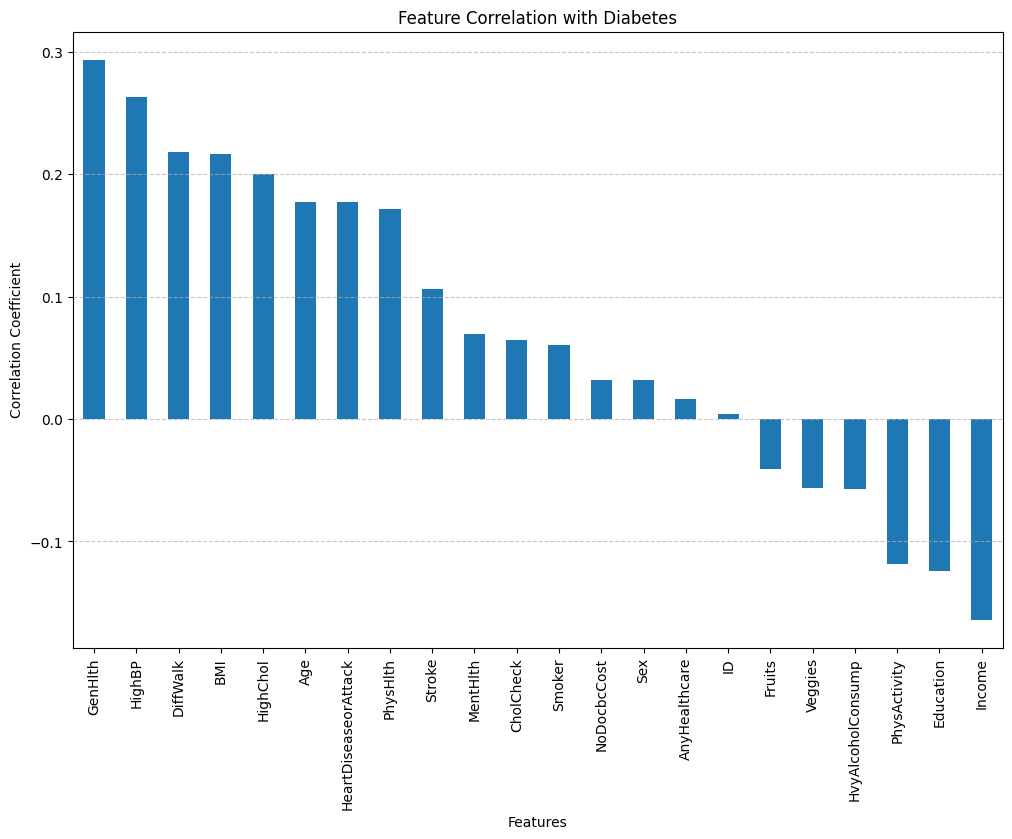

In [12]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Focus on correlations with the target variable
diabetes_correlations = correlation_matrix['Diabetes_binary'].sort_values(ascending=False)
print("\nFeatures correlated with Diabetes (sorted):")
print(diabetes_correlations)

# Visualize correlations with the target
plt.figure(figsize=(12, 8))
diabetes_correlations[1:].plot(kind='bar')  # Exclude self-correlation
plt.title("Feature Correlation with Diabetes")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4. Preprocessing

Usually in preprocessing we would handle missing values, encoding binary data (True -> 1), encoding categorical data, feature scaling. However, since the dataset is already clean and preprocessed, we will only address the class imbalance issue.
In the balanced datased, we have reduced the number of records with diabetes to match the number of records without diabetes, so that the dataset is balanced.

### 4.1 Class Imbalance

In [13]:

num_with_diabetes = df['Diabetes_binary'].value_counts()[1]

print("\nOriginal Dataset:")
print(f"- Total samples in the original dataset: {len(df)}")
print(f"- Samples with diabetes (class 1): {num_with_diabetes}")
print(f"- Samples without diabetes (class 0): {df['Diabetes_binary'].value_counts()[0]}")


df_no_diabetes = df[df['Diabetes_binary'] == 0].sample(n=num_with_diabetes, random_state=42)
df_with_diabetes = df[df['Diabetes_binary'] == 1]


df_balanced = pd.concat([df_no_diabetes, df_with_diabetes])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


print("\nBalanced Dataset:")
print(f"- Total samples in the balanced dataset: {len(df_balanced)}")
print(df_balanced['Diabetes_binary'].value_counts())

print(f"- Samples without diabetes (class 0): {df_balanced['Diabetes_binary'].value_counts()[0]}")
print(f"- Samples with diabetes (class 1): {df_balanced['Diabetes_binary'].value_counts()[1]}")



Original Dataset:
- Total samples in the original dataset: 253680
- Samples with diabetes (class 1): 35346
- Samples without diabetes (class 0): 218334

Balanced Dataset:
- Total samples in the balanced dataset: 70692
0    35346
1    35346
Name: Diabetes_binary, dtype: int64
- Samples without diabetes (class 0): 35346
- Samples with diabetes (class 1): 35346


### 4.2 Feature Selection

We need to explain which features we have chosen based on the data exploration above. We can use variance threshold, correlation matrix, kbest, rfe, boruta...

## 6. Machine Learning Model without Differential Privacy

We are importing the relevant libraries to train our models:

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

### 6.1 Data Splitting Strategy 

Before training our models we have to split the data into a training set and a test set. We have chosen a 80/20 split, which ensures we have enough training data for the model to learn patterns and enough data for performance evaluation. We have used stratified sampling to ensure that both the training set and test set includes a 50/50 split of records having diabetes or not.

In [15]:
X_balanced = df_balanced.drop('Diabetes_binary', axis=1) # drop the target column
y_balanced = df_balanced['Diabetes_binary']

X_imbalanced = df.drop('Diabetes_binary', axis=1) #drop the target column
y_imbalanced = df['Diabetes_binary']

# split into train (70%) and temp (30%)
X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# split temp set into validation (10%) and test (20%)
X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(
    X_temp_bal, y_temp_bal, test_size=2/3, random_state=42, stratify=y_temp_bal
)

# Imbalanced dataset
X_train_imb, X_temp_imb, y_train_imb, y_temp_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42, stratify=y_imbalanced
)

X_val_imb, X_test_imb, y_val_imb, y_test_imb = train_test_split(
    X_temp_imb, y_temp_imb, test_size=2/3, random_state=42, stratify=y_temp_imb
)

print(f"Balanced Training set: {X_train_bal.shape[0]} samples")
print(f"Balanced Validation set: {X_val_bal.shape[0]} samples")
print(f"Balanced Testing set: {X_test_bal.shape[0]} samples")

print("\nClass distribution in balanced training set:")
print(y_train_bal.value_counts(normalize=True))

print("\nClass distribution in balanced validation set:")
print(y_val_bal.value_counts(normalize=True))

print("\nClass distribution in balanced testing set:")
print(y_test_bal.value_counts(normalize=True))

print(f"\nImbalanced Training set: {X_train_imb.shape[0]} samples")
print(f"Imbalanced Validation set: {X_val_imb.shape[0]} samples")
print(f"Imbalanced Testing set: {X_test_imb.shape[0]} samples")

print("\nClass distribution in imbalanced training set:")
print(y_train_imb.value_counts(normalize=True))

print("\nClass distribution in imbalanced validation set:")
print(y_val_imb.value_counts(normalize=True))

print("\nClass distribution in imbalanced testing set:")
print(y_test_imb.value_counts(normalize=True))


Balanced Training set: 49484 samples
Balanced Validation set: 7069 samples
Balanced Testing set: 14139 samples

Class distribution in balanced training set:
0    0.5
1    0.5
Name: Diabetes_binary, dtype: float64

Class distribution in balanced validation set:
1    0.500071
0    0.499929
Name: Diabetes_binary, dtype: float64

Class distribution in balanced testing set:
0    0.500035
1    0.499965
Name: Diabetes_binary, dtype: float64

Imbalanced Training set: 177576 samples
Imbalanced Validation set: 25368 samples
Imbalanced Testing set: 50736 samples

Class distribution in imbalanced training set:
0    0.860668
1    0.139332
Name: Diabetes_binary, dtype: float64

Class distribution in imbalanced validation set:
0    0.860651
1    0.139349
Name: Diabetes_binary, dtype: float64

Class distribution in imbalanced testing set:
0    0.860671
1    0.139329
Name: Diabetes_binary, dtype: float64


### 6.2 Using all features

In [16]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

# Make predictions
y_pred = rf_model.predict(X_test_bal)

# Checking accuracy and classification report
print("Accuracy:", accuracy_score(y_test_bal, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_bal, y_pred))


Accuracy: 0.7451729259495014

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      7070
           1       0.72      0.79      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.74     14139
weighted avg       0.75      0.75      0.74     14139



### 6.3 Using selected features (balanced dataset)

In [17]:
# Define important features
important_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                      'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                      'CholCheck', 'Smoker', 'NoDocbcCost', 'Sex', 'AnyHealthcare', 
                      'Income', 'Education']

# Filter X_train_bal and X_test_bal to include only important features
X_train_important = X_train_bal[important_features]
X_test_important = X_test_bal[important_features]

# Train with the balanced filtered dataset
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_important, y_train_bal)

# Make predictions using the filtered test set
y_pred = rf_model.predict(X_test_important)

# Checking accuracy and classification report
print("Accuracy:", accuracy_score(y_test_bal, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_bal, y_pred))

Accuracy: 0.7345639719923616

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      7070
           1       0.72      0.78      0.75      7069

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139



- Precision: How many predicted positives are actually positive?
- Recall: How many actual positives were correctly identified?
- F1-score: A balance between precision and recall.
- Support: Number of actual occurrences of each class.

### 6.4 Using selected features (imbalanced dataset)

In [18]:
# Define important features
important_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                      'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                      'CholCheck', 'Smoker', 'NoDocbcCost', 'Sex', 'AnyHealthcare', 
                      'Income', 'Education']

# Filter the imbalanced training and test sets to include only important features
X_train_imb_important = X_train_imb[important_features]
X_test_imb_important = X_test_imb[important_features]

# Train with the imbalanced filtered dataset
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_imb_important, y_train_imb)

# Make predictions using the filtered test set
y_pred = rf_model.predict(X_test_imb_important)

# Checking accuracy and classification report
print("Accuracy:", accuracy_score(y_test_imb, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_imb, y_pred))

Accuracy: 0.8551915799432356

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     43667
           1       0.45      0.19      0.27      7069

    accuracy                           0.86     50736
   macro avg       0.67      0.58      0.60     50736
weighted avg       0.82      0.86      0.83     50736



**This model over prioritizes the majority class (0 - no diabetes), as it was trained with the imbalanced data.**

Comparison:

Balanced data (6.2) - Lower accuracy (74%) but much better at detecting class 1 - diabetes (79%), as it gives the same importance to both classes.

Imbalanced data (6.3) - Higher accuracy (86%) but poor detection of class 1 - diabetes (16%).

#### 6.4.1 Using validation set

In [19]:
important_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                      'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                      'CholCheck', 'Smoker', 'NoDocbcCost', 'Sex', 'AnyHealthcare', 
                      'Income', 'Education']

# Filter balanced training and test sets to include only important features
X_train_bal_important = X_train_bal[important_features]
X_test_bal_important = X_test_bal[important_features]
X_val_bal_important = X_val_bal[important_features]

# Train with the filtered balanced dataset
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_bal_important, y_train_bal)

# Make predictions using the filtered test set
y_pred_bal = rf_model.predict(X_test_bal_important)

# Checking accuracy and classification report for balanced test set
print("Balanced Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nBalanced Classification Report:")
print(classification_report(y_test_bal, y_pred_bal))

# Evaluate validation set - for documentation
y_pred_val_bal = rf_model.predict(X_val_bal_important)
print("\nBalanced Validation Accuracy:", accuracy_score(y_val_bal, y_pred_val_bal))
print("\nBalanced Validation Classification Report:")
print(classification_report(y_val_bal, y_pred_val_bal))

Balanced Accuracy: 0.7345639719923616

Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      7070
           1       0.72      0.78      0.75      7069

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139


Balanced Validation Accuracy: 0.7232989107370208

Balanced Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3534
           1       0.71      0.77      0.73      3535

    accuracy                           0.72      7069
   macro avg       0.72      0.72      0.72      7069
weighted avg       0.72      0.72      0.72      7069



#### 6.4.2 Using SMOTE balancing

In [20]:
from imblearn.over_sampling import SMOTE
from collections import Counter

important_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                      'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                      'CholCheck', 'Smoker', 'Veggies', 'HvyAlcoholConsump', 'PhysActivity', 
                      'Education' , 'Income']

X = df[important_features]
y = df['Diabetes_binary']

# Handle class imbalance using SMOTE
# SMOTE balances the dataset by generating synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", Counter(y))  # Shows original class distribution
print("After SMOTE:", Counter(y_resampled))  # Shows balanced class distribution

print("Original dataset shape:", X.shape, y.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)


# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

# Train with the balanced dataset split
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Checking accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Before SMOTE: Counter({0: 218334, 1: 35346})
After SMOTE: Counter({0: 218334, 1: 218334})
Original dataset shape: (253680, 17) (253680,)
Resampled dataset shape: (436668, 17) (436668,)
Accuracy: 0.8506423615086908

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84     43667
           1       0.82      0.90      0.86     43667

    accuracy                           0.85     87334
   macro avg       0.85      0.85      0.85     87334
weighted avg       0.85      0.85      0.85     87334



##### 6.4.2.1 Membership Inference Attack(MIA) 

The goal of this attack is to determine whether a given sample was used in training. 

It queries the model (6.6) with different data points and analyzes the confidence scores. This happens because the model behaves differently for data it has seen before and new data. As this one was trained without DP, it is easier to leak private data as it may have "memorized" training data. 

** To try with DP model(s) as well **

 Accuracy: 0.62
 Avg Train Confidence: 0.91
 Avg Test Confidence: 0.83
 Attack Threshold Used: 0.91



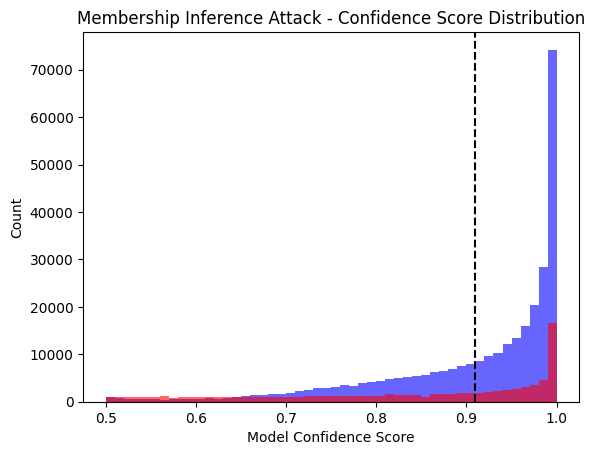

In [21]:
import numpy as np
from collections import Counter #?

assert 'rf_model' in locals(), "Random Forest model (rf_model) is not defined!" #if not defined, run 6.6

# Get confidence scores (highest probability prediction) for train and test samples
train_confidences = rf_model.predict_proba(X_train).max(axis=1)
test_confidences = rf_model.predict_proba(X_test).max(axis=1)

# Set attack threshold (mean confidence of training data)
threshold = np.mean(train_confidences)

# Attack: Predict "1" (member) if confidence > threshold, else "0" (non-member)
train_preds = [1 if c > threshold else 0 for c in train_confidences]
test_preds = [0 if c <= threshold else 1 for c in test_confidences]

# True labels: training samples = 1 (member), test samples = 0 (non-member)
y_true = [1] * len(train_preds) + [0] * len(test_preds)
y_pred = train_preds + test_preds

attack_accuracy = accuracy_score(y_true, y_pred)

train_mean_conf = np.mean(train_confidences)
test_mean_conf = np.mean(test_confidences)

print(f" Accuracy: {attack_accuracy:.2f}")
print(f" Avg Train Confidence: {train_mean_conf:.2f}")
print(f" Avg Test Confidence: {test_mean_conf:.2f}")
print(f" Attack Threshold Used: {threshold:.2f}\n")

import matplotlib.pyplot as plt

plt.hist(train_confidences, bins=50, alpha=0.6, label="Train (Member)", color='blue')
plt.hist(test_confidences, bins=50, alpha=0.6, label="Test (Non-Member)", color='red')
plt.axvline(threshold, color='black', linestyle='dashed', label="Attack Threshold")
plt.xlabel("Model Confidence Score")
plt.ylabel("Count")
plt.title("Membership Inference Attack - Confidence Score Distribution")
plt.show()


The 62% of accuracy means that the model partially leaks private information. It is possible to distinguish between training and testing samples.

##### 6.4.2.2 Attribute Inference Attack


Attribute Inference Attack on 'Income':
Attack Accuracy: 0.47
Avg Train Confidence: 0.91
Avg Test Confidence: 0.83



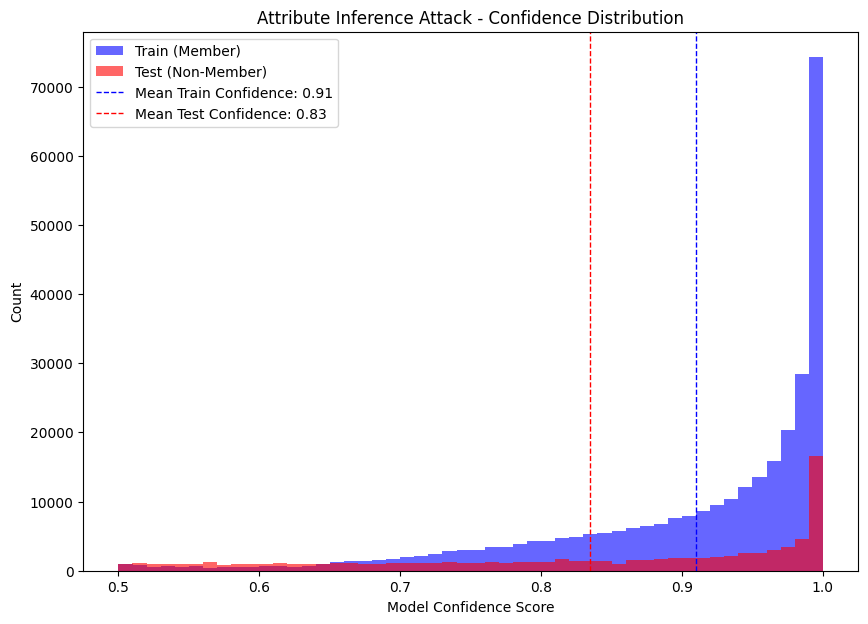

In [22]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier

assert 'rf_model' in locals(), "Random Forest model (rf_model) is not defined!" #if not defined, run 6.6

sensitive_feature = 'Income'

# Exclude 'Income' from training features - because we will be trying to infer this attribute
attack_features = [f for f in X_train.columns if f != sensitive_feature]

# Get confidence scores from the target model
# For each prediction, predict_proba() gives an array of probabilities for each class (8 in case of Income)
train_confidences = rf_model.predict_proba(X_train).max(axis=1)
test_confidences = rf_model.predict_proba(X_test).max(axis=1)

# Add confidence scores to the dataset
X_train_attack = X_train[attack_features].copy()
X_train_attack['model_confidence'] = train_confidences

X_test_attack = X_test[attack_features].copy()
X_test_attack['model_confidence'] = test_confidences


y_train_attack = X_train[sensitive_feature]
y_test_attack = X_test[sensitive_feature]

# Step 2: Train the Inference Model (using random forest)
inference_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
inference_model.fit(X_train_attack, y_train_attack)

# Step 3: Evaluate the Inference Model
y_pred_attack = inference_model.predict(X_test_attack)

attack_accuracy = accuracy_score(y_test_attack, y_pred_attack)

train_mean_conf = np.mean(train_confidences)
test_mean_conf = np.mean(test_confidences)

print("\nAttribute Inference Attack on 'Income':")
print(f"Attack Accuracy: {attack_accuracy:.2f}")
print(f"Avg Train Confidence: {train_mean_conf:.2f}")
print(f"Avg Test Confidence: {test_mean_conf:.2f}\n")

# Classification report
report = classification_report(y_test_attack, y_pred_attack, output_dict=True)

def print_classification_report(report):
    headers = ["Metric"] + [str(label) for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')]
    rows = [
        ["Precision"] + [report[label]['precision'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
        ["Recall"] + [report[label]['recall'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
        ["F1-Score"] + [report[label]['f1-score'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
        ["Support"] + [report[label]['support'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')]
    ]

    # Add macro and weighted averages
    rows.append(["Macro Avg", report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], report['macro avg']['support']])
    rows.append(["Weighted Avg", report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'], report['weighted avg']['support']])
    rows.append(["Accuracy", "", "", report['accuracy'], ""])

    print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".2f"))

# Step 4: Visualize the Confidence Distribution

plt.figure(figsize=(10, 7))
plt.hist(train_confidences, bins=50, alpha=0.6, label="Train (Member)", color='blue')
plt.hist(test_confidences, bins=50, alpha=0.6, label="Test (Non-Member)", color='red')
plt.axvline(train_mean_conf, color='blue', linestyle='dashed', linewidth=1, label=f"Mean Train Confidence: {train_mean_conf:.2f}")
plt.axvline(test_mean_conf, color='red', linestyle='dashed', linewidth=1, label=f"Mean Test Confidence: {test_mean_conf:.2f}")
plt.xlabel("Model Confidence Score")
plt.ylabel("Count")
plt.legend()
plt.title("Attribute Inference Attack - Confidence Distribution")
plt.show()


The attack achieved 47% accuracy, meaning it correctly inferred the income level of individuals nearly half the time. As the Income attribute has 8 levels, it is normal that the accuracy is lower. If the attack tried to guess randomly, it would be around 12,5% (1/8 *100). Therefore data is leaking. 

Also, the model showed higher confidence on training data (0.91) than test data (0.83), indicating a potential privacy risk.

##### 6.4.2.3 Find most exposed individuals and the analyzing the infered data

In [23]:
import pandas as pd
from tabulate import tabulate

# Add predictions and confidence to the test dataset for analysis
vulnerable_data = X_test_attack.copy()
vulnerable_data['True_Income'] = y_test_attack.values
vulnerable_data['Predicted_Income'] = y_pred_attack

# Calculate prediction correctness
vulnerable_data['Correct_Prediction'] = (vulnerable_data['True_Income'] == vulnerable_data['Predicted_Income'])

# Fidn top 20 most vulnerable individuals (highest confidence)
most_vulnerable = vulnerable_data.sort_values(by='model_confidence', ascending=False).head(20)

print("Most Vulnerable Individuals (Top 20 by Confidence Score):")
print(tabulate(most_vulnerable[['model_confidence', 'True_Income', 'Predicted_Income', 'Correct_Prediction']],
               headers='keys', tablefmt='pretty'))


Most Vulnerable Individuals (Top 20 by Confidence Score):
+--------+------------------+-------------+------------------+--------------------+
|        | model_confidence | True_Income | Predicted_Income | Correct_Prediction |
+--------+------------------+-------------+------------------+--------------------+
| 151176 |       1.0        |      8      |        8         |        True        |
| 406312 |       1.0        |      2      |        2         |        True        |
| 32354  |       1.0        |      8      |        8         |        True        |
| 414866 |       1.0        |      6      |        6         |        True        |
| 50714  |       1.0        |      8      |        8         |        True        |
| 381937 |       1.0        |      8      |        8         |        True        |
| 136177 |       1.0        |      7      |        6         |       False        |
| 158749 |       1.0        |      8      |        8         |        True        |
| 102807 |       1

The 20 most vulnerable individuals had a model confidence of 1.0, meaning the model was completely certain about their predicted income. 16 out of 20 predictions were completely correct (80%), highlighting a significant privacy concern for these individuals.

## 7. Applying Differential Privacy Techniques

### 7.1 Model Agnostic Private Learning (MAPL)

#### 7.1.1 Implementing the functions for applying MAPL

Importing libraries:

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.base import clone

Implementing function that adds noise to prediction probabilities:

In [25]:
# Function to add noise to prediction probabilities (output perturbation)
def add_laplace_noise(predictions, epsilon=1.0):
    """
    Add Laplace noise to predictions to achieve differential privacy
    
    Parameters:
    - predictions: original prediction probabilities
    - epsilon: privacy parameter (lower = more privacy but less accuracy)
    
    Returns:
    - noisy_predictions: predictions with Laplace noise added
    """
    # Scale parameter for Laplace distribution 
    sensitivity = 1.0  # Maximum change in prediction when one training example changes
    scale = sensitivity / epsilon  
    
    # Generate Laplace noise
    noise = np.random.laplace(0, scale, predictions.shape)
    
    # Add noise to predictions
    noisy_predictions = predictions + noise
    
    # Clip values to be between 0 and 1
    noisy_predictions = np.clip(noisy_predictions, 0, 1)
    
    return noisy_predictions

Implementing function for making differentially private predictions:

In [26]:
# Function for prediction-based MAPL
def mapl_predict(model, X, epsilon=1.0):
    """
    Make differentially private predictions using MAPL
    
    Parameters:
    - model: trained ML model with predict_proba method
    - X: features for prediction
    - epsilon: privacy parameter
    
    Returns:
    - Private binary predictions
    """
    # Get original probability predictions
    probabilities = model.predict_proba(X)
    
    # Add Laplace noise to the probabilities
    private_probabilities = add_laplace_noise(probabilities, epsilon)
    
    # Convert probabilities to binary predictions
    private_predictions = (private_probabilities[:, 1] >= 0.5).astype(int)
    
    return private_predictions, private_probabilities


Implementing function for evaluating model with different privacy levels:

In [27]:
# Function to evaluate models with different privacy levels
def evaluate_privacy_utility_tradeoff(model, X_test, y_test, epsilons=[0.01, 0.1, 0.5, 1.0, 10.0, 100.0]):
    """
    Evaluate model performance across different privacy levels
    
    Parameters:
    - model: trained ML model
    - X_test: test features
    - y_test: test labels
    - epsilons: list of privacy parameters to test
    
    Returns:
    - results: dataframe with evaluation metrics for each privacy level
    """
    results = []
    
    # Get non-private baseline performance
    baseline_pred = model.predict(X_test)
    baseline_accuracy = accuracy_score(y_test, baseline_pred)
    baseline_probas = model.predict_proba(X_test)[:, 1]
    baseline_auc = roc_auc_score(y_test, baseline_probas)
    
    results.append({
        'epsilon': 'Baseline (No Privacy)',
        'accuracy': baseline_accuracy,
        'auc': baseline_auc,
        'privacy_level': 'None'
    })
    
    # Evaluate performance at different privacy levels
    for epsilon in epsilons:
        private_pred, private_probas = mapl_predict(model, X_test, epsilon)
        accuracy = accuracy_score(y_test, private_pred)
        auc = roc_auc_score(y_test, private_probas[:, 1])
        
        # Determine privacy level label
        if epsilon < 0.1:
            privacy_level = 'Very High'
        elif epsilon < 1.0:
            privacy_level = 'High'
        elif epsilon < 10.0:
            privacy_level = 'Medium'
        else:
            privacy_level = 'Low'
            
        results.append({
            'epsilon': epsilon,
            'accuracy': accuracy,
            'auc': auc,
            'privacy_level': privacy_level
        })
    
    return pd.DataFrame(results)


Implementing function for training an ensemble of models for more robust predictions:

In [28]:
# Implement MAPL with ensemble approach (more robust to noise)
def train_mapl_ensemble(X_train, y_train, n_models=10, sample_fraction=0.8, 
                        base_model=RandomForestClassifier(n_estimators=100, random_state=42),
                        epsilon=1.0):
    """
    Train an ensemble of models for more robust private predictions
    
    Parameters:
    - X_train: training features
    - y_train: training labels
    - n_models: number of models in ensemble
    - sample_fraction: fraction of data to sample for each model
    - base_model: base model to clone for ensemble
    - epsilon: privacy parameter for final predictions
    
    Returns:
    - ensemble: list of trained models
    - epsilon: privacy parameter used
    """
    ensemble = []
    n_samples = int(len(X_train) * sample_fraction)
    
    for i in range(n_models):
        # Sample data with replacement
        indices = np.random.choice(len(X_train), n_samples, replace=True)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]
        
        # Clone and train model
        model = clone(base_model)
        model.fit(X_sample, y_sample)
        ensemble.append(model)
    
    return ensemble, epsilon

def predict_with_mapl_ensemble(ensemble, X, epsilon):
    """
    Make differentially private predictions using an ensemble
    
    Parameters:
    - ensemble: list of trained models
    - X: features for prediction
    - epsilon: privacy parameter
    
    Returns:
    - Private predictions
    """
    # Get predictions from each model
    all_probas = np.zeros((len(X), 2))
    
    # Divide epsilon budget among models
    model_epsilon = epsilon / len(ensemble)
    
    for model in ensemble:
        # Get probability predictions
        probas = model.predict_proba(X)
        
        # Add noise to each model's predictions
        noisy_probas = add_laplace_noise(probas, model_epsilon)
        
        # Accumulate predictions
        all_probas += noisy_probas
    
    # Average predictions
    avg_probas = all_probas / len(ensemble)
    
    # Make final binary predictions
    predictions = (avg_probas[:, 1] >= 0.5).astype(int)
    
    return predictions, avg_probas

#### 7.1.2 Applying MAPL to the Balanced Dataset

Using the functions we defined in 7.1.1 to apply MAPL to the balanced dataset

Getting the feature names used in the original model...
Original model was trained with these features: ['GenHlth' 'HighBP' 'DiffWalk' 'BMI' 'HighChol' 'Age'
 'HeartDiseaseorAttack' 'PhysHlth' 'Stroke' 'MentHlth' 'CholCheck'
 'Smoker' 'Veggies' 'HvyAlcoholConsump' 'PhysActivity' 'Education'
 'Income']
Using the existing Random Forest model from section 6.4
Original Balanced Model Accuracy: 0.7346
Original Classification Report (from section 6.4):
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      7070
           1       0.72      0.78      0.75      7069

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139



Evaluating privacy-utility tradeoff with MAPL...

Privacy-Utility Tradeoff Results:
                 epsilon  accuracy       auc privacy_level
0  Baseline (No Privacy)  0.944551  0.986948          None
1                 

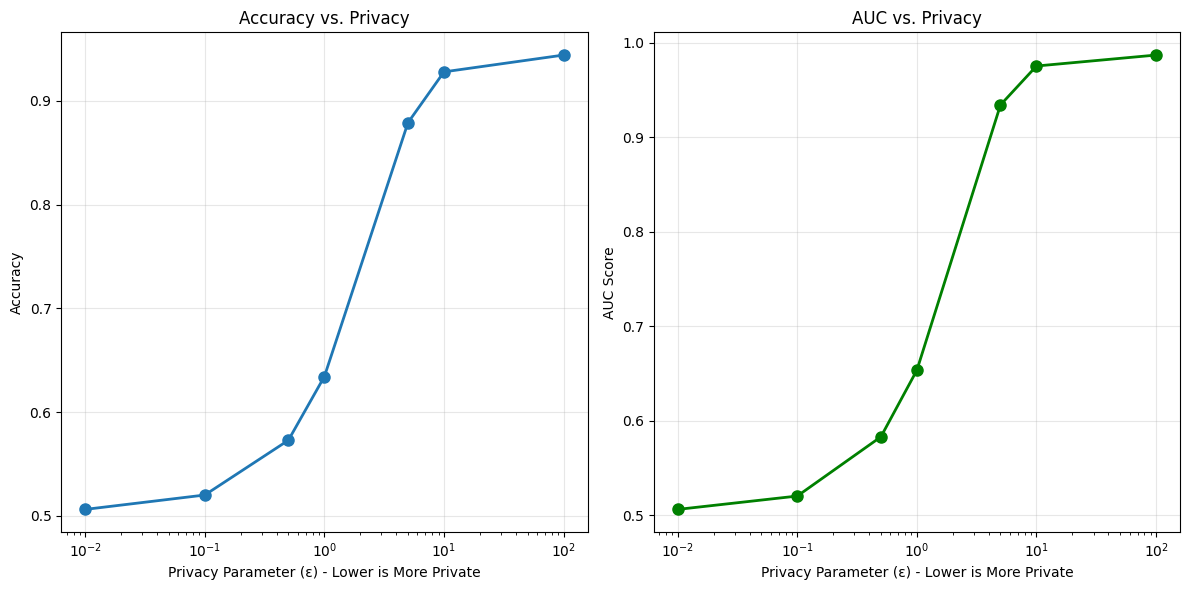



Training MAPL ensemble model...

MAPL Ensemble Model Accuracy (ε=1.0): 0.5192

MAPL Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      7070
           1       0.52      0.59      0.55      7069

    accuracy                           0.52     14139
   macro avg       0.52      0.52      0.52     14139
weighted avg       0.52      0.52      0.52     14139



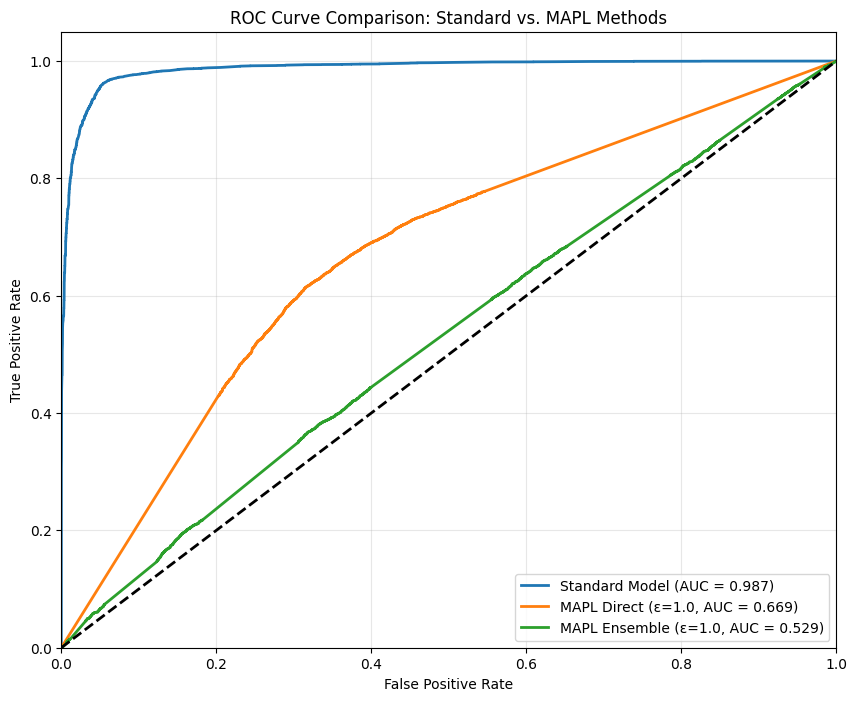

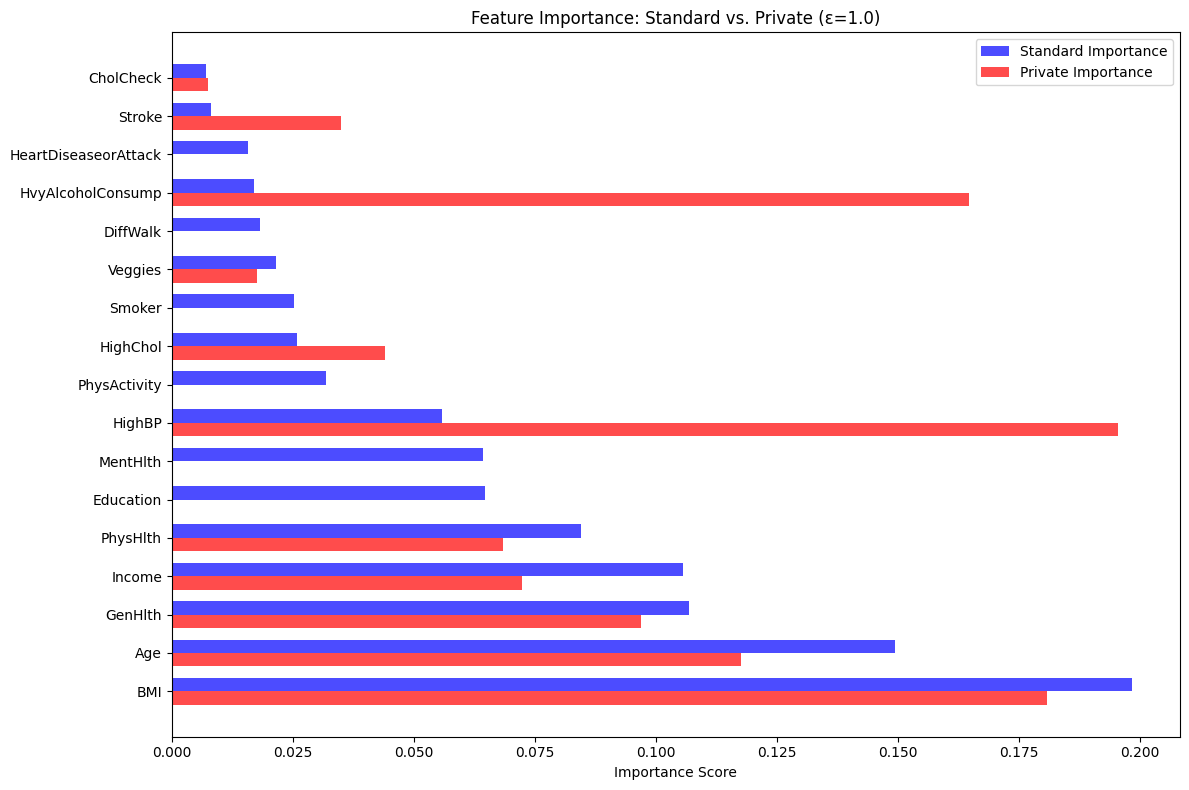

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# First, we need to ensure we're using the exact same features that were used to train the model
# Extract the features used in the original training
print("Getting the feature names used in the original model...")
if hasattr(rf_model, 'feature_names_in_'):
    original_features = rf_model.feature_names_in_
    print(f"Original model was trained with these features: {original_features}")
else:
    # Important features we used earlier
    original_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                       'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                       'CholCheck', 'Smoker', 'NoDocbcCost', 'Sex', 'AnyHealthcare', 
                       'Income', 'Education']
    print(f"Using features from section 6.4: {original_features}")

# Ensure test data has the same features in same order
X_test_for_mapl = X_test_bal[original_features].copy()
X_train_for_mapl = X_train_bal[original_features].copy()

# Use the original model
print("Using the existing Random Forest model from section 6.4")
print(f"Original Balanced Model Accuracy: {accuracy_score(y_test_bal, y_pred_bal):.4f}")
print("Original Classification Report (from section 6.4):")
print(classification_report(y_test_bal, y_pred_bal))

# Apply MAPL output perturbation with different privacy levels
print("\n\nEvaluating privacy-utility tradeoff with MAPL...")
epsilon_values = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
privacy_results = evaluate_privacy_utility_tradeoff(rf_model,  # Using existing rf_model from section 6.4
                                                  X_test_for_mapl,  # Using the correctly filtered features 
                                                  y_test_bal, 
                                                  epsilons=epsilon_values)

# Display privacy-utility tradeoff
print("\nPrivacy-Utility Tradeoff Results:")
print(privacy_results)

# Visualize privacy-utility tradeoff
plt.figure(figsize=(12, 6))

# Plot only the values with numeric epsilon (exclude baseline)
numeric_results = privacy_results[privacy_results['epsilon'] != 'Baseline (No Privacy)'].copy()
numeric_results['epsilon'] = numeric_results['epsilon'].astype(float)

plt.subplot(1, 2, 1)
plt.plot(numeric_results['epsilon'], numeric_results['accuracy'], 'o-', linewidth=2, markersize=8)
plt.xscale('log')  # Log scale for epsilon
plt.xlabel('Privacy Parameter (ε) - Lower is More Private', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs. Privacy', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(numeric_results['epsilon'], numeric_results['auc'], 'o-', linewidth=2, color='green', markersize=8)
plt.xscale('log')  # Log scale for epsilon
plt.xlabel('Privacy Parameter (ε) - Lower is More Private', fontsize=10)
plt.ylabel('AUC Score', fontsize=10)
plt.title('AUC vs. Privacy', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train and apply MAPL ensemble for more robust results
print("\n\nTraining MAPL ensemble model...")
epsilon = 1.0  # Choose a reasonable privacy level
# Use the filtered features for training ensemble
ensemble, ensemble_epsilon = train_mapl_ensemble(X_train_for_mapl, y_train_bal, 
                                               n_models=10, 
                                               sample_fraction=0.8,
                                               base_model=RandomForestClassifier(n_estimators=100, random_state=42),
                                               epsilon=epsilon)

# Make private predictions with the ensemble
ensemble_pred, ensemble_probas = predict_with_mapl_ensemble(ensemble, X_test_for_mapl, epsilon)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test_bal, ensemble_pred)
print(f"\nMAPL Ensemble Model Accuracy (ε={epsilon}): {ensemble_accuracy:.4f}")
print("\nMAPL Ensemble Model Classification Report:")
print(classification_report(y_test_bal, ensemble_pred))

# Compare ROC curves
plt.figure(figsize=(10, 8))

# Standard model curve (using existing rf_model)
standard_probas = rf_model.predict_proba(X_test_for_mapl)[:, 1]
fpr_standard, tpr_standard, _ = roc_curve(y_test_bal, standard_probas)
roc_auc_standard = auc(fpr_standard, tpr_standard)
plt.plot(fpr_standard, tpr_standard, 
         label=f'Standard Model (AUC = {roc_auc_standard:.3f})',
         linewidth=2)

# MAPL with direct perturbation
_, mapl_direct_probas = mapl_predict(rf_model, X_test_for_mapl, epsilon)
fpr_mapl, tpr_mapl, _ = roc_curve(y_test_bal, mapl_direct_probas[:, 1])
roc_auc_mapl = auc(fpr_mapl, tpr_mapl)
plt.plot(fpr_mapl, tpr_mapl, 
         label=f'MAPL Direct (ε={epsilon}, AUC = {roc_auc_mapl:.3f})',
         linewidth=2)

# MAPL ensemble
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_bal, ensemble_probas[:, 1])
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
plt.plot(fpr_ensemble, tpr_ensemble, 
         label=f'MAPL Ensemble (ε={epsilon}, AUC = {roc_auc_ensemble:.3f})',
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Standard vs. MAPL Methods')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Generate feature importance analysis with privacy considerations
if hasattr(rf_model, 'feature_importances_'):
    # Get feature importances from existing model
    importances = rf_model.feature_importances_
    
    # Add noise to feature importances for privacy
    def privatize_importances(importances, epsilon=1.0):
        sensitivity = 1.0/len(importances)  # Maximum impact of one sample on importances
        scale = sensitivity/epsilon
        noise = np.random.laplace(0, scale, size=len(importances))
        noisy_importances = importances + noise
        # Ensure all importances are non-negative
        noisy_importances = np.maximum(0, noisy_importances)
        # Re-normalize to sum to 1
        noisy_importances = noisy_importances / noisy_importances.sum()
        return noisy_importances
    
    # Get private feature importances
    private_importances = privatize_importances(importances, epsilon)
    
    # Get feature names
    if hasattr(rf_model, 'feature_names_in_'):
        features = rf_model.feature_names_in_
    else:
        features = original_features
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': features,
        'Standard Importance': importances,
        'Private Importance': private_importances
    })
    
    # Sort by standard importance
    importance_df = importance_df.sort_values('Standard Importance', ascending=False)
    
    # Visualize comparison
    plt.figure(figsize=(12, 8))
    
    # Plot standard vs private importances
    ind = np.arange(len(importance_df))
    width = 0.35
    
    plt.barh(ind + width/2, importance_df['Standard Importance'], width, label='Standard Importance', color='blue', alpha=0.7)
    plt.barh(ind - width/2, importance_df['Private Importance'], width, label='Private Importance', color='red', alpha=0.7)
    
    plt.yticks(ind, importance_df['Feature'])
    plt.xlabel('Importance Score')
    plt.title('Feature Importance: Standard vs. Private (ε={})'.format(epsilon))
    plt.legend()
    plt.tight_layout()
    plt.show()

Evaluation & Performance Metrics with MAPL:

In [30]:
# 8. Evaluation & Performance Metrics with MAPL
print("\n================= MAPL EVALUATION SUMMARY =================")
print("\nPrivacy-Utility Tradeoff Summary:")
print("--------------------------------------------------------")
print("| Privacy Level | Epsilon | Accuracy | AUC  | Privacy Impact |")
print("--------------------------------------------------------")

for _, row in privacy_results.iterrows():
    if row['epsilon'] == 'Baseline (No Privacy)':
        print(f"| {row['privacy_level']:<13} | {'N/A':<7} | {row['accuracy']:.4f} | {row['auc']:.4f} | None            |")
    else:
        # Calculate privacy impact as percentage decrease from baseline
        baseline = privacy_results[privacy_results['epsilon'] == 'Baseline (No Privacy)']
        accuracy_impact = (baseline['accuracy'].values[0] - row['accuracy']) / baseline['accuracy'].values[0] * 100
        print(f"| {row['privacy_level']:<13} | {row['epsilon']:<7} | {row['accuracy']:.4f} | {row['auc']:.4f} | {accuracy_impact:.2f}% decrease |")

print("--------------------------------------------------------")

# Calculate average performance metrics
avg_accuracy_high_privacy = privacy_results[
    (privacy_results['privacy_level'] == 'High') | 
    (privacy_results['privacy_level'] == 'Very High')
]['accuracy'].mean()

avg_accuracy_med_low_privacy = privacy_results[
    (privacy_results['privacy_level'] == 'Medium') | 
    (privacy_results['privacy_level'] == 'Low')
]['accuracy'].mean()

print(f"Average accuracy with high privacy (ε < 1.0): {avg_accuracy_high_privacy:.4f}")
print(f"Average accuracy with medium/low privacy (ε ≥ 1.0): {avg_accuracy_med_low_privacy:.4f}")

# Find best privacy-utility tradeoff
numeric_results = privacy_results[privacy_results['epsilon'] != 'Baseline (No Privacy)'].copy()
if not numeric_results.empty:
    numeric_results['epsilon'] = numeric_results['epsilon'].astype(float)
    
    # Calculate a combined score that balances privacy and utility
    # Lower epsilon is better for privacy, higher accuracy is better for utility
    numeric_results['privacy_score'] = 1 / numeric_results['epsilon']
    max_privacy = numeric_results['privacy_score'].max()
    max_accuracy = numeric_results['accuracy'].max()
    
    # Normalize scores to [0,1] range
    numeric_results['norm_privacy'] = numeric_results['privacy_score'] / max_privacy
    numeric_results['norm_accuracy'] = numeric_results['accuracy'] / max_accuracy
    
    # Combined score (equal weighting)
    numeric_results['combined_score'] = (numeric_results['norm_privacy'] + numeric_results['norm_accuracy']) / 2
    
    # Find best tradeoff
    best_tradeoff = numeric_results.loc[numeric_results['combined_score'].idxmax()]
    
    print(f"\nRecommended privacy parameter (best tradeoff): ε = {best_tradeoff['epsilon']}")
    print(f"- Accuracy: {best_tradeoff['accuracy']:.4f}")
    print(f"- Privacy level: {best_tradeoff['privacy_level']}")


================= MAPL EVALUATION SUMMARY =================

Privacy-Utility Tradeoff Summary:
--------------------------------------------------------
| Privacy Level | Epsilon | Accuracy | AUC  | Privacy Impact |
--------------------------------------------------------
| None          | N/A     | 0.9446 | 0.9869 | None            |
| Very High     | 0.01    | 0.5063 | 0.5063 | 46.39% decrease |
| High          | 0.1     | 0.5202 | 0.5205 | 44.93% decrease |
| High          | 0.5     | 0.5730 | 0.5831 | 39.34% decrease |
| Medium        | 1.0     | 0.6343 | 0.6536 | 32.84% decrease |
| Medium        | 5.0     | 0.8789 | 0.9341 | 6.95% decrease |
| Low           | 10.0    | 0.9279 | 0.9752 | 1.77% decrease |
| Low           | 100.0   | 0.9441 | 0.9868 | 0.05% decrease |
--------------------------------------------------------
Average accuracy with high privacy (ε < 1.0): 0.5332
Average accuracy with medium/low privacy (ε ≥ 1.0): 0.8463

Recommended privacy parameter (best tradeoff): ε

## 7.2 Gradient Descend

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import opacus
import numpy

print(numpy.__version__) # min 1.21
print(opacus.__version__) # min 1.3

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_important)
X_test_scaled = scaler.transform(X_test_important)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_bal.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)  # Binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = FeedForwardNN(input_dim=X_train_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

privacy_engine = opacus.PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=5.0,     # Set desired privacy budget
    target_delta=1e-5,
    max_grad_norm=1.0,
    epochs=5
)

model.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = torch.argmax(predictions, dim=1)
    acc = (predicted_classes == y_test_tensor).float().mean().item()
    print(f"Accuracy: {acc:.4f}")

epsilon = privacy_engine.get_epsilon(delta=1e-5)
print(f"Final ε: {epsilon:.2f}")

1.24.4
1.5.3


C:\Users\NMarek\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\NMarek\AppData\Roaming\Python\Python39\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\NMarek\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result

Epoch 1, Loss: 0.4865
Epoch 2, Loss: 0.6873
Epoch 3, Loss: 0.6435
Epoch 4, Loss: 0.4587
Epoch 5, Loss: 0.7761
Accuracy: 0.7427
Final ε: 4.99


## 8. Evaluation & Performance Metrics

Missing

## 9. Results & Discussion

Missing

## 10. Conclusion & Future Work

Missing